# Tutorial: Sit to Stand and Stand to Sit Detection

**Author:** Masoud Abedinifar

**Last update:** Fri 16 Feb 2024

## Learning objectives
By the end of this tutorial:
- You can load data from a recording that belongs to one of the available datasets,
- Apply the Pham Sit to Stand and Stand to Sit Detection algorithm.
- Interpret the detected postural transitions for further analysis.

## Import libraries
The necessary libraries such as numpy, matplotlib.pyplot, and dataset are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the 'ngmt' library and its dependencies if you haven't already.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ngmt.datasets import keepcontrol
from ngmt.modules.ssd import PhamSittoStandStandtoSitDetection
from ngmt.config import cfg_colors

## Data Preparation

To implement Sit to Stand and Stand to Sit Detection algorithm, we load example data.


In [2]:
# The 'file_path' variable holds the absolute path to the data file
file_path = (
    r"\\uni-kiel.de\files\bigprojects\neurogeriatrics_data\Keep Control\Data\lab dataset\rawdata\sub-pp001\motion\sub-pp001_task-homePart1_tracksys-imu_motion.tsv"
)

In [3]:
# In this example, we use "imu" as tracking_system and "pelvis" as tracked points.
tracking_sys = "imu"
tracked_points = {tracking_sys: ["pelvis"]}

# Print tracking system and tracking points
print(f"tracking system: {tracking_sys}",)
print(f"tracked points: {tracked_points}",)

tracking system: imu
tracked points: {'imu': ['pelvis']}


In [4]:
# The 'keepcontrol.load_recording' function is used to load the data from the specified file_path
recording = keepcontrol.load_recording(
    file_name=file_path, tracking_systems=[tracking_sys], tracked_points=tracked_points
)

# Print recording data
print(f"Recording: {recording}")

Recording: NGMTRecording(data={'imu':        pelvis_ACC_x  pelvis_ACC_y  pelvis_ACC_z  pelvis_ANGVEL_x  \
0          0.976592      0.008796     -0.246601        -0.174850   
1          0.977521      0.015647     -0.233898         0.000000   
2          0.971204      0.004373     -0.234379        -0.090663   
3          0.972195      0.006852     -0.243666         0.265513   
4          0.969222      0.008310     -0.242656         0.090663   
...             ...           ...           ...              ...   
85242      0.947236      0.041013     -0.323733         0.090663   
85243      0.952129      0.041985     -0.325177         0.174850   
85244      0.947236      0.040528     -0.320317         0.440363   
85245      0.951200      0.041985     -0.323733         0.000000   
85246      0.945317      0.041013     -0.325706         0.265513   

       pelvis_ANGVEL_y  pelvis_ANGVEL_z  pelvis_MAGN_x  pelvis_MAGN_y  \
0            -1.223942        -0.438799       0.426030      -0.064213   

In [5]:
# Load lower back acceleration data
acceleration_data = recording.data[tracking_sys][
    ["pelvis_ACC_x", "pelvis_ACC_y", "pelvis_ACC_z"]
]

# Print acceleration data
print(f"acceleration_data (g): {acceleration_data}")

acceleration_data (g):        pelvis_ACC_x  pelvis_ACC_y  pelvis_ACC_z
0          0.976592      0.008796     -0.246601
1          0.977521      0.015647     -0.233898
2          0.971204      0.004373     -0.234379
3          0.972195      0.006852     -0.243666
4          0.969222      0.008310     -0.242656
...             ...           ...           ...
85242      0.947236      0.041013     -0.323733
85243      0.952129      0.041985     -0.325177
85244      0.947236      0.040528     -0.320317
85245      0.951200      0.041985     -0.323733
85246      0.945317      0.041013     -0.325706

[85247 rows x 3 columns]


In [6]:

# Load lower back gyro data
gyro_data = recording.data[tracking_sys][
    ["pelvis_ANGVEL_x", "pelvis_ANGVEL_y", "pelvis_ANGVEL_z"]
]

# Print gyro data
print(f"gyro_data (deg/s): {gyro_data}")

gyro_data (deg/s):        pelvis_ANGVEL_x  pelvis_ANGVEL_y  pelvis_ANGVEL_z
0            -0.174850        -1.223942        -0.438799
1             0.000000        -0.788078         0.087760
2            -0.090663        -1.135889         0.000000
3             0.265513        -0.788078        -0.438799
4             0.090663        -0.959782        -0.175520
...                ...              ...              ...
85242         0.090663        -0.523918         0.523184
85243         0.174850        -1.400049         0.000000
85244         0.440363        -0.264160         0.175520
85245         0.000000         0.088053        -0.087760
85246         0.265513        -0.788078         0.351040

[85247 rows x 3 columns]


In [7]:
# Get the corresponding sampling frequency directly from the recording
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "pelvis_ACC_x"
]["sampling_frequency"].values[0]

# Print sampling frequency and its type
print(f"sampling frequency: {sampling_frequency} Hz")
print(f"type of sampling frequency: {type(sampling_frequency)}")

sampling frequency: 200 Hz
type of sampling frequency: <class 'numpy.int64'>


## Visualisation of the Data
The raw acceleration and gyro data including components of x, y and z axis are plotted.

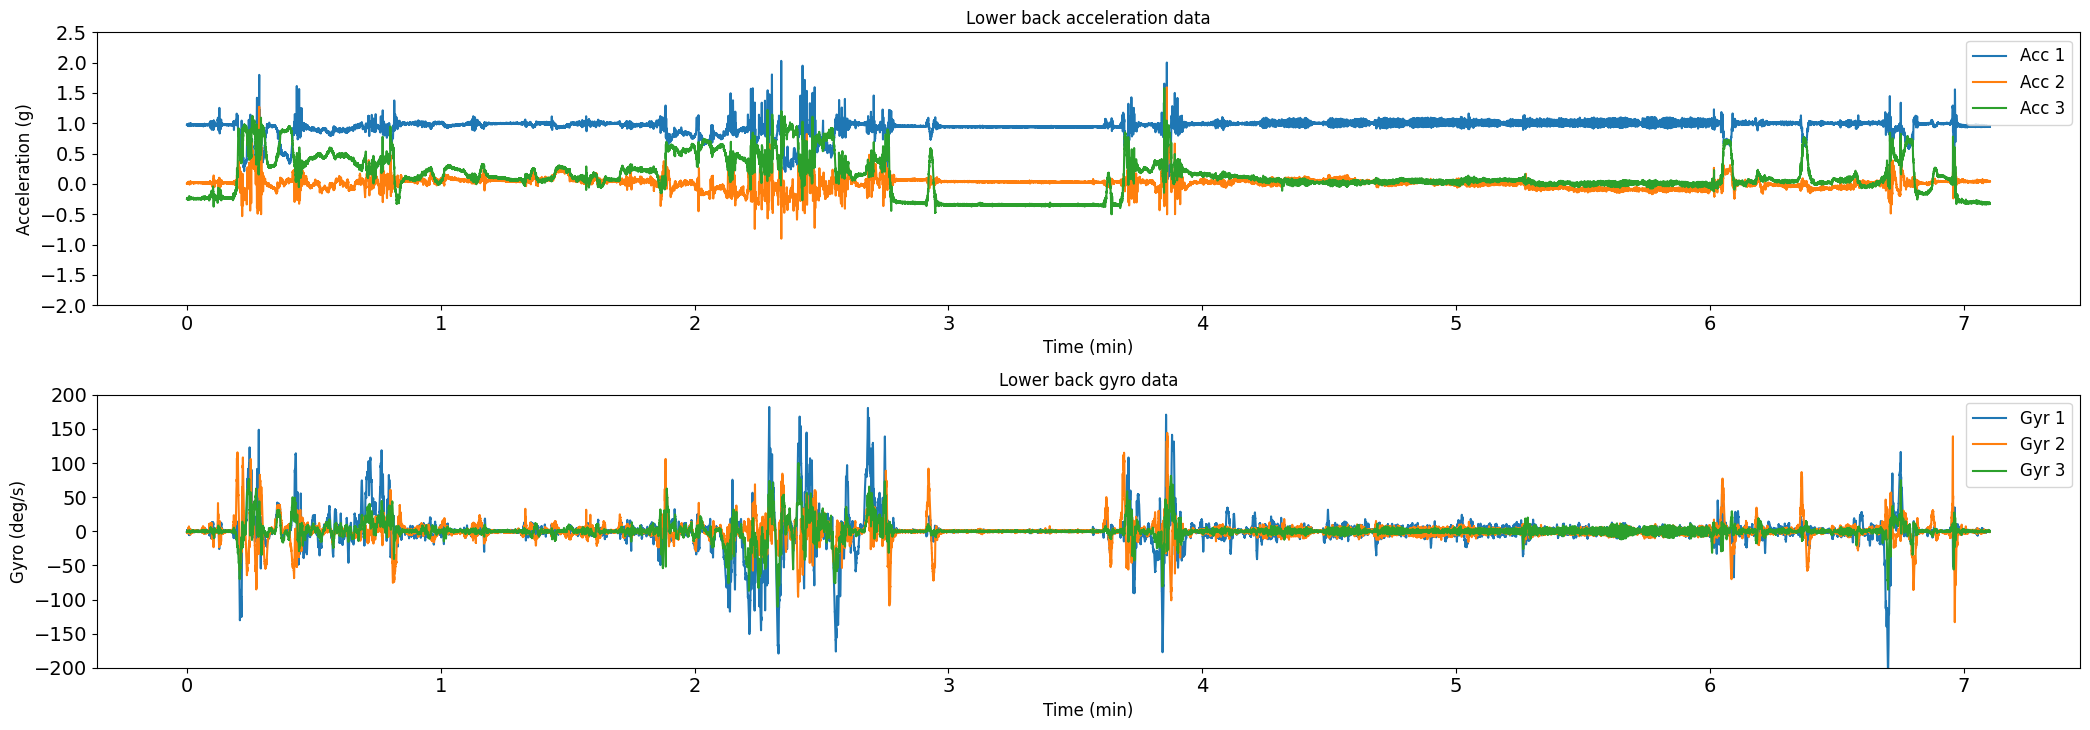

In [8]:
# Plot acceleration and gyro in subplots
fig = plt.figure(figsize=(21, 7.4))

# Subplot 1: Acceleration data
ax1 = plt.subplot(211)
for i in range(3):
    ax1.plot(
        np.arange(len(acceleration_data)) / sampling_frequency / 60,
        acceleration_data[f"pelvis_ACC_{chr(120 + i)}"],
        label=f"Acc {i + 1}",
    )
ax1.set_title("Lower back acceleration data")
ax1.set_ylabel(f"Acceleration (g)", fontsize=12)
ax1.set_xlabel(f"Time (min)", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)
ax1.set_ylim(-2, 2.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Subplot 2: Gyro data
ax2 = plt.subplot(212)
for i in range(3):
    ax2.plot(
        np.arange(len(gyro_data)) / sampling_frequency / 60,
        gyro_data[f"pelvis_ANGVEL_{chr(120 + i)}"],
        label=f"Gyr {i + 1}",
    )
ax2.set_title("Lower back gyro data")
ax2.set_ylabel(f"Gyro (deg/s)", fontsize=12)
ax2.set_xlabel(f"Time (min)", fontsize=12)
ax2.legend(loc="upper right", fontsize=12)
ax2.set_ylim(-200, 200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout()
plt.show()


## Applying pham sit to stand and stand to sit detection algorithm
Now, we are running pham sit to stand and stand to sit detection algorithm from gsd module [`NGMT.ngmt.modules.ssd._pham.SittoStandStandtoSitDetection`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/ssd/_pham.py) to detect sit to stand and stand to sit. The inputs consist of accelerometer and gyroscope data (N, 6) for the x, y, and z axes, the initial sampling frequency of the data.

In [9]:
# Put acceleration and gyro data in the input data as pandas Dataframe which will be used as input of the algorithm
input_data = [acceleration_data, gyro_data]

# Concatenate acceleration_data and gyro_data along axis=1 (columns)
input_data = pd.concat([acceleration_data, gyro_data], axis=1)

# Print input data and its type
print(f"input data: {input_data}")

input data:        pelvis_ACC_x  pelvis_ACC_y  pelvis_ACC_z  pelvis_ANGVEL_x  \
0          0.976592      0.008796     -0.246601        -0.174850   
1          0.977521      0.015647     -0.233898         0.000000   
2          0.971204      0.004373     -0.234379        -0.090663   
3          0.972195      0.006852     -0.243666         0.265513   
4          0.969222      0.008310     -0.242656         0.090663   
...             ...           ...           ...              ...   
85242      0.947236      0.041013     -0.323733         0.090663   
85243      0.952129      0.041985     -0.325177         0.174850   
85244      0.947236      0.040528     -0.320317         0.440363   
85245      0.951200      0.041985     -0.323733         0.000000   
85246      0.945317      0.041013     -0.325706         0.265513   

       pelvis_ANGVEL_y  pelvis_ANGVEL_z  
0            -1.223942        -0.438799  
1            -0.788078         0.087760  
2            -1.135889         0.000000  
3  

In [ ]:
# Create an instance of the PhamSittoStandStandtoSitDetection class
pham = PhamSittoStandStandtoSitDetection()

# Call the sit to satnd and stand to sit detection using pham.detect
pham = pham.detect(
    data=input_data, sampling_freq_Hz=sampling_frequency
)

# Print events and their corresponding information
pt_events = pham.postural_transitions_
print(f"pt_events: {pt_events}")